In [43]:
import tifffile as tf
import pandas as pd
import numpy as np
from skimage.transform import hough_circle, hough_circle_peaks
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
from skimage.draw import circle_perimeter
from skimage.filters import gaussian
from skimage.morphology import dilation, disk

# This notebook experiments with different image processing techniques to optimise GUV membrane detection


In [67]:
def create_bin_edges(image,n=3,alpha = 1):
    bin_image = np.zeros_like(image)
    # threshold = threshold_otsu(images[1])
    threshold = np.median(image)+ n*np.std(image)
    bin_image[image> threshold ] = 1
    bin_image[image > threshold+alpha*np.std(image)]=0
    return bin_image

In [49]:
def dilate_detected_edges(img,r = 3):
    #dilates the thin edges found in membrane
    kernel = disk(r)
    return dilation(img,kernel)

In [37]:
def clip_detections(accums,cx,cy,radii,N=8):
    accums = accums[:N]
    cx = cx[:N]
    cy = cy[:N]
    radii = radii[:N]
    return accums,cx,cy,radii

In [38]:
def find_duplicates(cxcy):
    #cxcy -> ndarray of shape (N_detections,2): initial detected centre coordinates of circles
    
    for i in range(cxcy.shape[0]):
        peak = cxcy[i]
        rest  = cxcy[i+1:]

        dists = np.linalg.norm(rest - peak,axis = 1)
        if i == 0:

            multi_detections = np.nonzero(dists < 20)[0] +i+1
            
        else:
            multi_detections = np.concatenate((multi_detections,np.nonzero(dists < 20)[0]+i+1))

            
    return np.unique(multi_detections)


In [39]:
def remove_duplicates(accum,cx,cy,radii,duplicate_coords):
    #accum -> 1darray: ordered results of voting on hough circles
    #cx -> 1darray: most likely x coords by voting
    #cy -> 1darray: most likely y coords by voting
    #duplicate_coords -> 1darray: indices of duplicate detections to remove
    
    accum = np.delete(accum,duplicate_coords)
    cx = np.delete(cx,duplicate_coords)
    cy = np.delete(cy,duplicate_coords)
    radii = np.delete(radii,duplicate_coords)
    return accum,cx,cy,radii

In [40]:

def segment_detections(image,hough_vals):
    #image -> ndarray (512,512): raw image 
    #hough_vals -> tuple of 4 1d_arrays : post processed hough circle detection
    ##############  (accumulator,c_x,c_y,radii)
    
    
    detections_img  = np.zeros_like(image)
    i = 1
    for x,y, rad in zip(hough_vals[1],hough_vals[2],hough_vals[3]):

        circy,circx = circle_perimeter(y,x,rad)
        detections_img[circy[circx < 512][circy[circx <512] < 512],circx[circx < 512][circy[circx<512] < 512]] = i
        i +=1
    # plt.imshow(images[1])
    # plt.imshow(detections_img,alpha=1)

    return detections_img




In [12]:
def get_ax(rows=2, cols=2, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [30]:
def add_to_display(ax,image,mode):
    assert mode in ['image','smoothed','binary','Hough']
    
    if mode == 'image':
        
        ax[0][0].imshow(image)
        ax[0][0].set_title('Raw')
        
    elif mode == 'smoothed':
        
        ax[0][1].imshow(image)
        ax[0][1].set_title('Gaussian smoothing')
        
    elif mode == 'binary':
        
        ax[1][0].imshow(image)
        ax[1][0].set_title('Binary')
        
    else:
        ax[1][1].imshow(image)
        ax[1][1].set_title('Hough Detections')
    

In [68]:
def detect_guvs(image,radii,N,n,sigma = 2,alpha = 1):
    
    #Instantiate ax
    ax = get_ax()
    
    add_to_display(ax,image,'image')
    #smooth the image first
    smoothed_image = gaussian(image,sigma)
    #create binary edges for circle detection
    
    add_to_display(ax,smoothed_image,'smoothed')
    
    bin_image = create_bin_edges(image,n,alpha)
    #plt.imshow(bin_i'multi_detections'mage)
    #circle detection with Hough transform
    add_to_display(ax,bin_image,'binary')
    
    hough_res = hough_circle(bin_image,radii)

    hough_vals = hough_circle_peaks(hough_res,radii)

    #clip detections: we don't expect there to be more than a few GUVs in one frame

    hough_vals = clip_detections(*hough_vals,N)

    #reshape the peak coordinates to exploit some numpy optimizations

    cxcy = np.vstack((hough_vals[1],hough_vals[2])).T


    #Due to bug in scikit image hough circle peaks function, need to remove duplicates

    duplicates = find_duplicates(cxcy)

    hough_vals = remove_duplicates(*hough_vals,duplicates)

    #Segment instances of circles to get individual GUV membranes

    detections_img = segment_detections(image,hough_vals)
            
    detections_img = dilate_detected_edges(detections_img)
    add_to_display(ax,detections_img,'Hough')
    plt.show()
    
    return detections_img

In [63]:
#Import the video: shape is (Num_channels,N,512,512)
tifvid = tf.TiffFile('./tifs1pc025pcCALIB2/tifs/Image0001.tif')

#Instantiate Hough hyperparameters


#configurations
radii = np.arange(20,35,2)
radii25 = np.arange(15,35,2)
N = 100
n=2


In [65]:
frames = tifvid.asarray()

In [53]:
frames

array([[[170, 150, 311, ..., 163, 154, 161],
        [152, 154, 159, ..., 154, 505, 288],
        [160, 176, 153, ..., 171, 172, 158],
        ...,
        [277, 170, 162, ..., 158, 159, 156],
        [160, 168, 232, ..., 154, 166, 494],
        [165, 159, 151, ..., 448, 196, 166]],

       [[174, 153, 168, ..., 178, 163, 165],
        [223, 339, 335, ..., 222, 162, 166],
        [176, 167, 164, ..., 164, 175, 213],
        ...,
        [155, 161, 159, ..., 200, 168, 250],
        [160, 207, 296, ..., 286, 184, 162],
        [348, 185, 169, ..., 181, 162, 430]]], dtype=uint16)

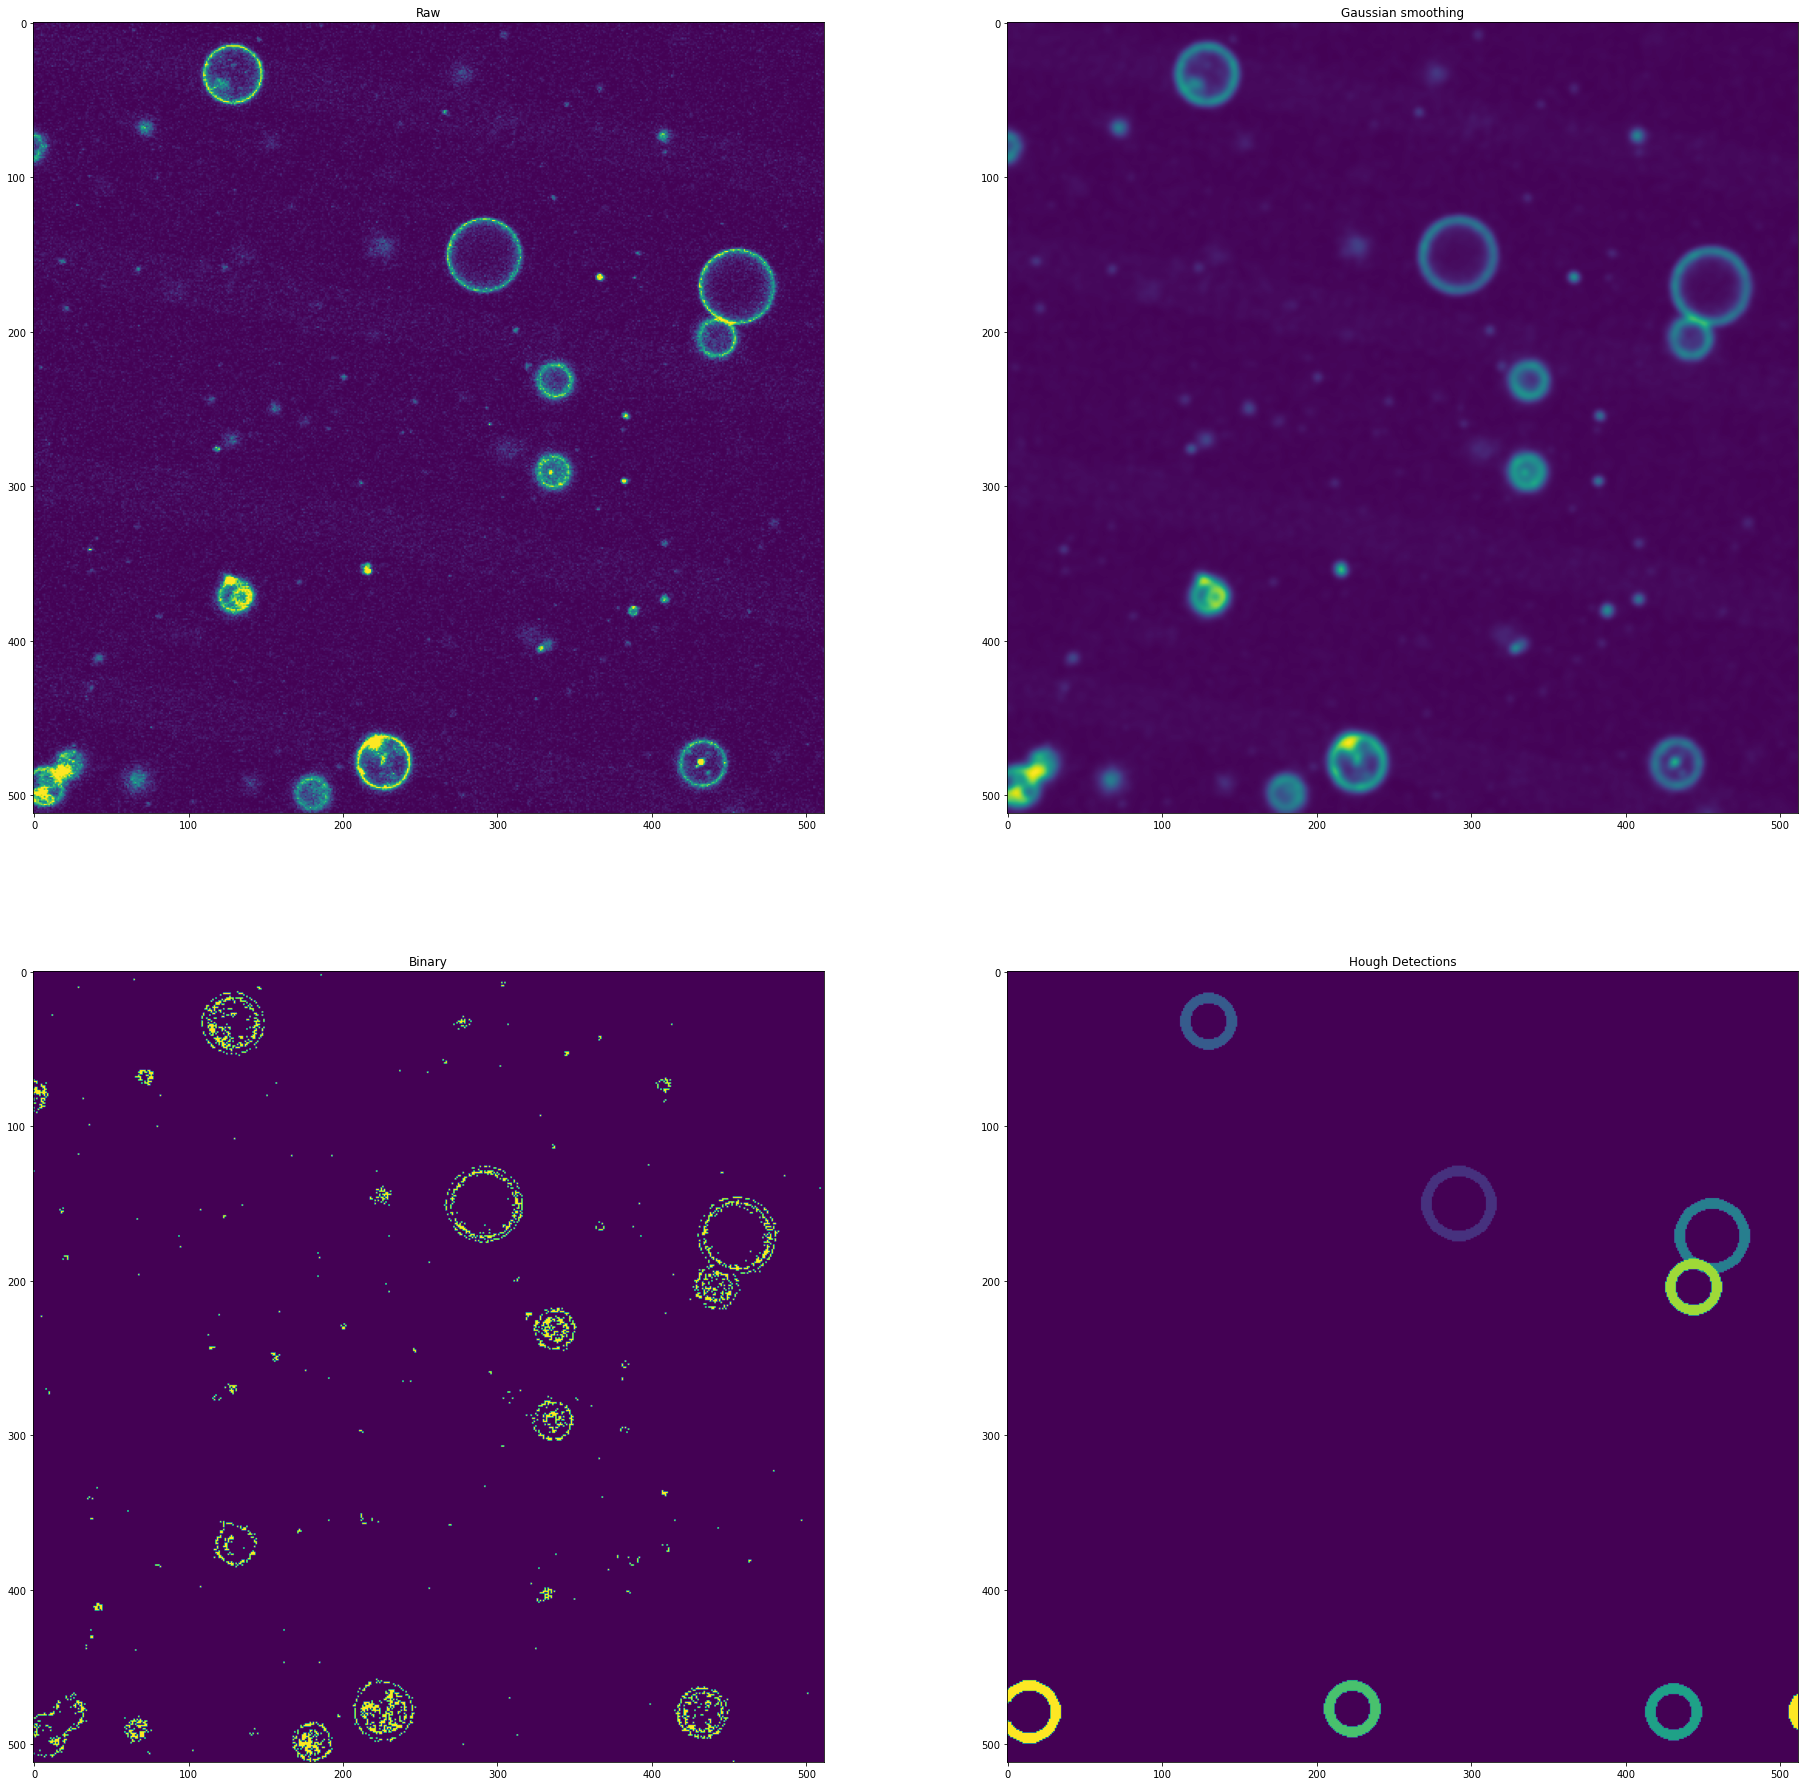

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [69]:
detect_guvs(frames[1],radii25,N,n,alpha = 2)